# Diffusion HP settings

In [3]:
import sys
sys.path.append('..')
from dotenv import load_dotenv
import torch
import os

%load_ext autoreload
gpu_index=7



# Needed for log_prob
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_math_sdp(True)


load_dotenv()

if 'MODEL_DIR' in os.environ:
    model_root = os.environ['MODEL_DIR']
else:
    model_root = './runs'

if 'DATA_DIR' in os.environ:
    data_root = os.environ['DATA_DIR']
else:
    data_root = './data'
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Drawing samples

Here we figure out the ideal hyperparameter setting to get samples from our diffusion models.

In [4]:

import os
import torch
from model_zoo.utils import load_model_with_checkpoints



print(model_root)
device = f"cuda:{gpu_index}" if torch.cuda.is_available() else "cpu"

grayscale_model = load_model_with_checkpoints(
    config = {
        'config_dir': 'checkpoints-hg9x5r0n/diffusion_fashion-mnist_interparental_bxnuw7zk_final/run_config.json',
        'checkpoint_dir': 'checkpoints-hg9x5r0n/diffusion_fashion-mnist_interparental_bxnuw7zk_final/checkpoints/de_score-based-VP-diffusion_latest.pt'
    },
    root=model_root, 
    device=device,
)

rgb_model = load_model_with_checkpoints(
    config = {
        'config_dir': 'checkpoints-znod8v3z/diffusion_cifar10_distinctions_aep6z5pr_final/run_config.json',
        'checkpoint_dir': 'checkpoints-znod8v3z/diffusion_cifar10_distinctions_aep6z5pr_final/checkpoints/de_score-based-VP-diffusion_latest.pt'
    },
    root=model_root, 
    device=device,
)
grayscale_model.to(device)
rgb_model.to(device)
print("Done loading!")

/data2/hamid/miniconda3/envs/ood-detection/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/data2/hamid/dysweep_logs/
Done loading!


Now let's look at samples

In [5]:
import matplotlib.pyplot as plt
import torchvision
from tqdm import tqdm

def get_samples(model):
    epss = [0.000001, 0.00001, 0.00005, 0.0001, 0.001, 0.005, 0.01, 0.1, 1.0]

    # Create a figure with 9 subplots
    fig, axes = plt.subplots(3, 3, figsize=(8,8))
    assert len(epss) == len(axes.flatten())


    for ax, eps in tqdm(zip(axes.flatten(), epss), total=len(epss), desc="getting samples"): # Generate 1k points and plot them
        samples = model.sample(9, steps=1000, eps=eps) 
        samples = torch.clip(torchvision.utils.make_grid(samples, nrow=3)/255., 0, 1)
        ax.imshow(samples.permute(1, 2, 0).cpu().numpy())
        ax.set_title(f'$\epsilon$ = {eps}')
        
    fig.tight_layout()


getting samples:   0%|          | 0/9 [00:00<?, ?it/s]

getting samples: 100%|██████████| 9/9 [03:33<00:00, 23.71s/it]


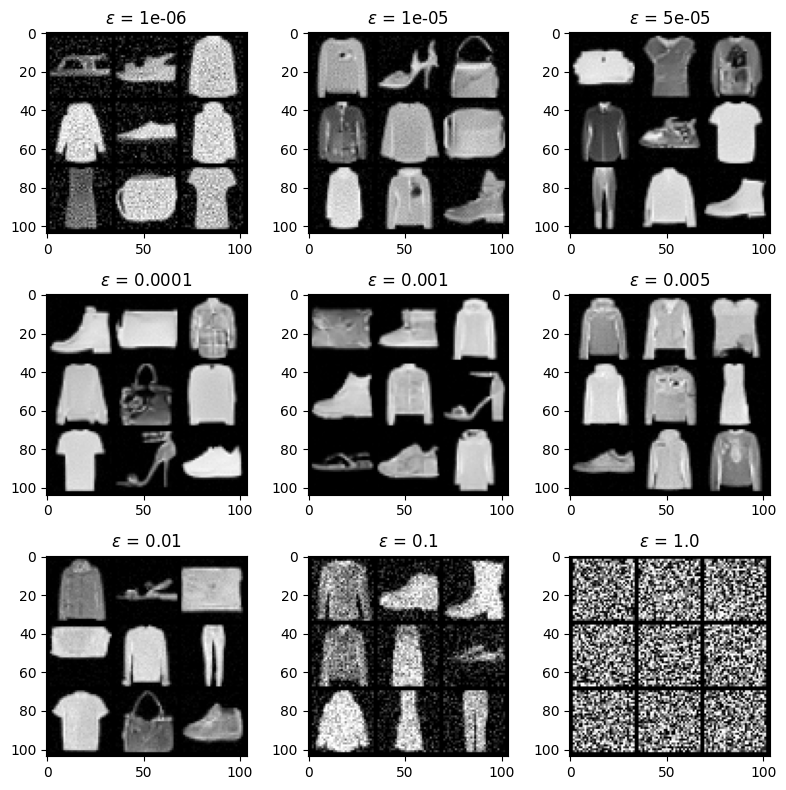

In [6]:
get_samples(grayscale_model)

getting samples: 100%|██████████| 9/9 [03:37<00:00, 24.21s/it]


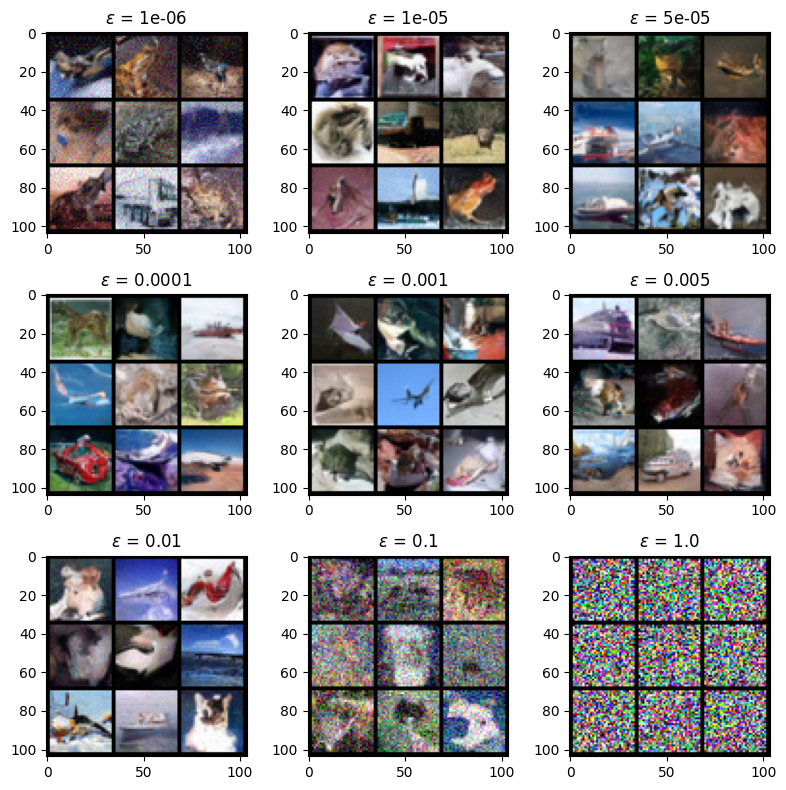

In [7]:
get_samples(rgb_model)

## 

## Likelihood Computation

In [8]:
%autoreload 2
from model_zoo.datasets import get_loaders

grayscale_dloader, _, _ = get_loaders(
    dataset='fashion-mnist', 
    make_valid_loader=False,
    train_batch_size=9,
    valid_batch_size=9,
    test_batch_size=9,
    additional_dataset_args=dict(
        resize_image = [32, 32]
    ),
    device=device,
    data_root=data_root,
    unsupervised=True,
    
)
grayscale_data_batch = next(iter(grayscale_dloader))

rgb_dloader, _, _ = get_loaders(
    dataset='cifar10', 
    make_valid_loader=False,
    train_batch_size=9,
    valid_batch_size=9,
    test_batch_size=9,
    device=device,
    data_root=data_root,
    unsupervised=True,
)
rgb_data_batch = next(iter(rgb_dloader))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In this notebook, we will figure out the ideal hyperparameter setting for likelihood computation. We consider a sample diffusion model that has been trained and then estimates its likelihood on different hyperparameter settings. The main hyperparameters are:

1. `eps`: This is the epsilon that we consider when we run the log_prob computation.
2. `num_steps`: The number of steps to take for solving the Euler Murayama.
3. `Hutchinson Count`: The number of vectors to sample for computing the trace of the Hessian.



In [9]:
import numpy as np
import time
epss = [0.00001, 0.00005, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 1.0]
hutchinson_sample_count = [10, 25, 50, 500]
num_stepss = [10, 25, 50, 100, 250]

# epss = [0.005]
# hutchinson_sample_count = [10, 25]
# num_stepss = [10, 25]

def get_grids(model, data_batch):
    
    # Create a figure with 9 subplots

    rng = tqdm(epss, total=len(epss), desc="getting samples")
    all_tables = []
    
    for eps in rng: # Generate 1k points and plot them
        table = [[None for __ in range(len(num_stepss))] for _ in range(len(hutchinson_sample_count))]
        
        for i, num_samples in enumerate(hutchinson_sample_count):
            for j, num_steps in enumerate(num_stepss):
                rng.set_description(f"filling element [{i + 1}/{len(hutchinson_sample_count)}], [{j + 1}/{len(num_stepss)}] with {num_samples} samples and {num_steps} steps")
                # get current time in seconds 
                ts = time.time()
                if num_samples == -1:
                    log_probs = model.log_prob(
                        data_batch, 
                        steps=num_steps, 
                        eps=eps,
                        trace_calculation_kwargs=dict(
                            method='deterministic'
                        ),
                        verbose=0,
                    )
                else:
                    log_probs = model.log_prob(
                        data_batch, 
                        steps=num_steps, 
                        eps=eps,
                        trace_calculation_kwargs=dict(
                            method='hutchinson_rademacher',
                            sample_count=num_samples,
                        ),
                        verbose=0,
                    )
                duration = time.time() - ts
                table[i][j] = f"{round(log_probs.mean().item(), 3)} +/- {round(log_probs.std().item(), 3)} ({round(duration, 3)}s)"
        print("Epsilon is", eps)
        # print the table and format it with the column names and row names
        # the rows are the number of samples, the columns are the number of steps
        
        print("Table is:")
        print("num_samples\\num_steps", end='\t\t\t')
        for step_count in  num_stepss:
            print(f"{step_count}", end='\t\t\t')
        print("")
        for i, row in enumerate(table):
            print(f"{hutchinson_sample_count[i]}", end='\t\t\t')
            for val in row:
                print(val, end='\t\t\t')
            print("")

In [10]:
get_grids(grayscale_model, grayscale_data_batch)

filling element [1/4], [1/5] with 10 samples and 10 steps:   0%|          | 0/9 [00:00<?, ?it/s]

filling element [1/4], [5/5] with 10 samples and 250 steps:   0%|          | 0/9 [10:46<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
get_grids(rgb_model, rgb_data_batch)